In [707]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
import datetime 
import scipy.optimize as sco
import scipy.interpolate as sci
from pylab import plt, mpl
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
import random

In [2]:
from arch import arch_model

In [3]:
plt.style.use('seaborn')

https://www.bankrate.com/investing/best-etfs/ 

Invesco QQQ Trust (QQQ) - Non-financial Nasdaq - Tech-heavy

iShares Core S&P 500 ETF (IVV) - Black Rock - very low cost

ProShares VIX Short-Term Futures ETF (VIXY) - ETF on VIX (volatility)

Vanguard High Dividend Yield (VYM) - FTSE high-dividend paying stocks

Vanguard Health Care Index Fund (VHT)

https://www.thebalance.com/best-etfs-4173857

iShares Russell 2000 ETF (IWM) - Small cap stock

SPDR Gold Trust (GLD)

Vanguard FTSE Developed Markets (VEA) - Develeoped contries except USA




Vanguard FTSE Europe Index Fund ETF Shares (VGK)

iShares Short Treasury Bond ETF (SHV)

iShares 20+ Year Treasury Bond ETF (TLT)

iShares Core € Corp Bond UCITS ETF (IEAC)

In [32]:
# List shares of interest as Yahoo Fiance "Ticker"/"Symbol"
mylist = ['QQQ', 'IVV', 'VYM', 'VHT', 'IWM', 'GLD', 'VEA', 'VGK', 'TLT']
# mylist = ["danske.co", "MAERSK-B.CO", 'CHR.CO', "NZYM-B.CO", 'LUN.CO', 'GN.CO', 'GEN.CO']
    #'VIXY', 'SHV' -- 'CARL-B.CO', 'ORSTED.CO'
noa = len(mylist)

# Create DataFrame to store data
df = pd.DataFrame()
df_change = pd.DataFrame()
rets = pd.DataFrame()

In [33]:
for x in mylist:
    df[x] = pdr.get_data_yahoo(x, start=datetime.datetime(2017, 1, 1))['Adj Close'] 
    df_change['pct_c_{}'.format(x)] = df[x].pct_change()   # 
    rets[x] = np.log(df[x] / df[x].shift(1))*100

In [34]:
rets.describe().round(4)

,QQQ,IVV,VYM,VHT,IWM,GLD,VEA,VGK,TLT
count,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000
mean,0.0725,0.0479,0.0306,0.0505,0.0231,0.0319,0.0260,0.0277,0.0306
std,1.1030,0.8061,0.7122,0.8905,0.9750,0.6458,0.7245,0.7881,0.5987
min,-4.6847,-4.2245,-4.3248,-4.4704,-4.3508,-1.9559,-4.1645,-4.3023,-1.7524
25%,-0.3516,-0.2178,-0.2478,-0.3045,-0.4666,-0.3882,-0.3609,-0.4039,-0.3608
50%,0.1286,0.0585,0.0505,0.1193,0.0931,0.0569,0.0866,0.0855,0.0474
75%,0.6269,0.4424,0.4142,0.5397,0.5807,0.3871,0.4401,0.4901,0.4204
max,6.0567,4.7884,3.8720,4.5268,4.6942,2.5367,3.0285,3.5895,2.1666


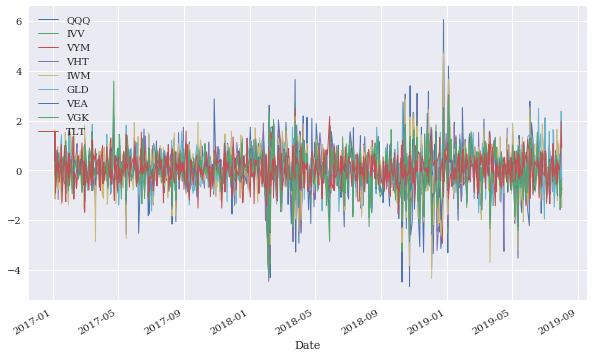

In [35]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
rets.plot(lw=1.0, figsize=(10,6))  #.cumsum()

In [36]:
# Random assigned weight
weights = np.random.random(noa)
weights /= np.sum(weights) 
weights

array([0.01261961, 0.08349817, 0.1244236 , 0.13894745, 0.1673794 ,
       0.11298911, 0.1068428 , 0.16639241, 0.08690745])

In [37]:
# Expected portfolio return (annualized)
EPR = np.sum(rets.mean() * weights) * 252

# Portfolio Variance annualized
PV = np.dot(weights.T, np.dot(rets.cov() * 252, weights))

# Portfolio Volatility (Standard deviation)
P_std = math.sqrt(PV)

display(EPR, PV, P_std)

8.379548610463749

88.30058565233522

9.39683913091712

In [38]:
# Monte Carlo simulation

def port_ret(weights):
    return np.sum(rets.mean() * weights) *252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    
p_rets = []
p_vols = []
    
for p in range (50000):
    weights = np.random.random(noa)
    weights /= np.sum(weights) 
    p_rets.append(port_ret(weights))
    p_vols.append(port_vol(weights))
    
p_rets = np.array(p_rets)
p_vols = np.array(p_vols)

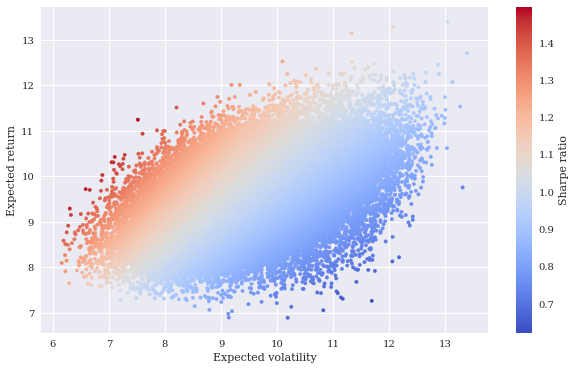

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker = '.', cmap='coolwarm')
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

In [40]:
# Maximisation of Sharpe Ratio  (Equal weights)

# Function to minimize
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

# Equality constraint
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for parameters
bnds = tuple((0,1) for x in range(noa))

# Equal weights 
eweights = np.array(noa * [1. / noa,])

print('Equal weight sharp ratio = ', -min_func_sharpe(eweights).round(4))

Equal weight sharp ratio =  1.0136


In [41]:
# Max return
#%%time
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
#print(opts)
print('opts = opt. port. weights = ', opts['x'].round(3))
print('port_ret = ', port_ret(opts['x']).round(3))
print('port_vol = ', port_vol(opts['x']).round(3))
print('Maximum Sharpe Ratio = ', port_ret(opts['x']) / port_vol(opts['x']))

opts = opt. port. weights =  [0.18  0.177 0.    0.017 0.    0.201 0.    0.    0.425]
port_ret =  10.539
port_vol =  6.666
Maximum Sharpe Ratio =  1.580930000821833


In [42]:
# Minimize Vol
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
print('weights = ', optv['x'].round(3))
print('Minimum vol = ', port_vol(optv['x']).round(3))
print('return = ', port_ret(optv['x']).round(3))
print('Sharpe ratio = ', (port_ret(optv['x']) / port_vol(optv['x'])).round(3))

weights =  [0.    0.    0.312 0.    0.026 0.185 0.051 0.    0.427]
Minimum vol =  5.767
return =  7.658
Sharpe ratio =  1.328


In [47]:
# Effecient Frontier pp. 224

# Binding Constraint for efficient frontier
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds
bnds = tuple((0,1) for x in weights)

# Target Return
trets = np.linspace(6.5, 15.0, 50) # We want to find minimum vol portfolios to each target return (trets).

tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])

# Store tvols as numpy array
tvols = np.array(tvols)


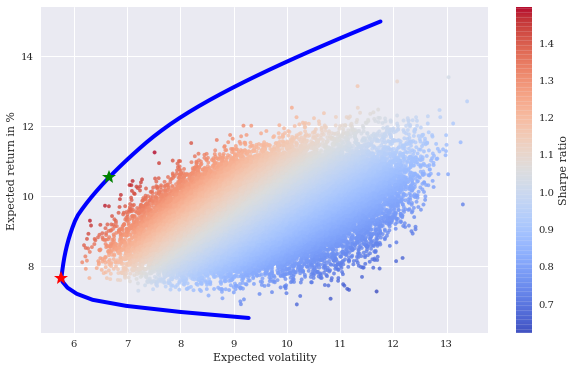

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=p_rets / p_vols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'g*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return in %')
plt.colorbar(label='Sharpe ratio')

In [49]:
# Capital Market Line pp. 425

# Index position of minimum vol portfolio
ind = np.argmin(tvols)
evols = tvols[ind:]     # Relevant portfolio vol
erets = trets[ind:]     # Relevant portfolio ret

tck = sci.splrep(evols, erets)   # Cubic splines interpolation on these values

def f(x):
    '''Effecient frontier function (splines approximation).'''
    return sci.splev(x, tck, der=0)

def df(x):
    '''First derivative of Efficient frontier fct.'''
    return sci.splev(x, tck, der=1)

In [50]:
# page 427
def equations(p, rf=1.0):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.2, 0.1])

print('Optimal parameter values = ', opt.round(4))

print('Check that eq holds:', np.round(equations(opt), 6))

Optimal parameter values =  [1.     1.4341 6.974 ]
Check that eq holds: [0. 0. 0.]


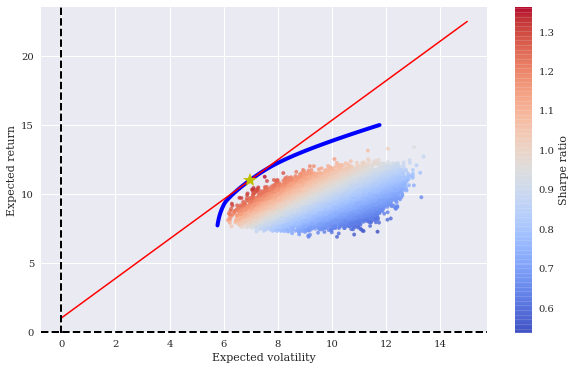

In [52]:
plt.figure(figsize=(10,6))
plt.scatter(p_vols, p_rets, c=(p_rets-1.0) / p_vols,                      # Check rf = 0.01
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)

cx = np.linspace(0.0, 15.0)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)

plt.plot(opt[2], f(opt[2]), 'y*', markersize=15)

plt.grid(True)

plt.axhline(0,color='k', ls='--', lw=2.0)
plt.axvline(0,color='k', ls='--', lw=2.0)

plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')

In [53]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - f(opt[2])},
    {'type': 'eq', 'fun': lambda x: np.sum(x)-1})

res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)

In [54]:
res

     fun: 6.974008786494111
     jac: array([12.05032486,  7.72392923,  5.73081857,  8.16832989,  7.15489346,
        4.90729713,  6.40837264,  6.23234123,  4.67685294])
 message: 'Optimization terminated successfully.'
    nfev: 70
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([2.53930273e-01, 8.82596934e-02, 1.32620626e-15, 3.12758395e-02,
       0.00000000e+00, 2.02541131e-01, 0.00000000e+00, 2.48321261e-16,
       4.23993062e-01])

In [55]:
print('weights:',res['x'].round(3))
print('return',port_ret(res['x']).round(4))
print('vol',port_vol(res['x']).round(4))

weights: [0.254 0.088 0.    0.031 0.    0.203 0.    0.    0.424]
return 11.0011
vol 6.974


## Moving on to GARCH modelleing

In [97]:
n_time = 100
n_test = 10
H = -n_time+n_test

parameters = np.zeros((noa,4))
forecasts = np.zeros((noa,n_test))
forecast_variance = np.zeros(noa)
std_resid = np.zeros((noa,len(train)))



for i,n in enumerate(mylist):
    # split into train/test
    train, test = rets[n][1:-n_time], rets[n][-n_time : H]
    #train, test = rets['IVV'][1:-n_test], rets['IVV'][-n_test:]

    # define GARCH model
    model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)
    # model = arch_model(train, p=1, o=1, q=1) # GJR Garch - just change parameters to 5 instead of 4

    # fit model
    res = model.fit(disp='off')

    # Save parameter estimates
    parameters[i][:] = res.params[:]
    
    # Save standardized residuals
    std_resid[i][:] = res.resid / res.conditional_volatility
    
    # forecast variance
    forecasts[i][:] = res.forecast(horizon=n_test).variance.dropna().values.T[:,0]
    forecast_variance[i] = forecasts[i].mean() # Each asset's forecasted variance for period n_test period ahead

In [57]:
# All mu (expected return)
F_mu = parameters[:, 0]

# Forecasted variances
F_var = forecast_variance
H

-90

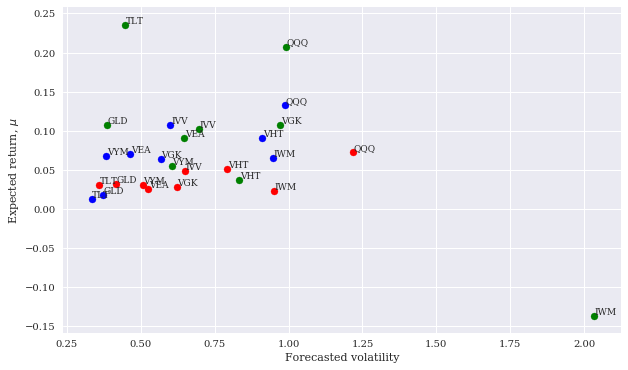

In [58]:
plt.figure(figsize=(10,6))
#plt.scatter(F_var, F_mu,  cmap='coolwarm')

for i,type in enumerate(mylist):
    x = F_var[i]
    y = F_mu[i]
    x2 = rets[type].var()
    y2 = rets[type].mean()
    
    # actual realization out-of-sample
    x3 = rets[-n_time:H][type].var()
    y3 = rets[-n_time:H][type].mean()
    
    
    plt.scatter(x, y, marker='o', color='b', label='Forecast')
    plt.scatter(x2, y2, marker='o', color='r', label='Historic')
    plt.scatter(x3, y3, marker='o', color='g', label='Actual out-of-sample')
    plt.text(x+0.002, y+0.002, type, fontsize=9)
    plt.text(x2+0.002, y2+0.002, type, fontsize=9)
    plt.text(x3+0.002, y3+0.002, type, fontsize=9)

plt.xlabel('Forecasted volatility')
plt.ylabel('Expected return, $\mu$')
#plt.legend()

plt.show()

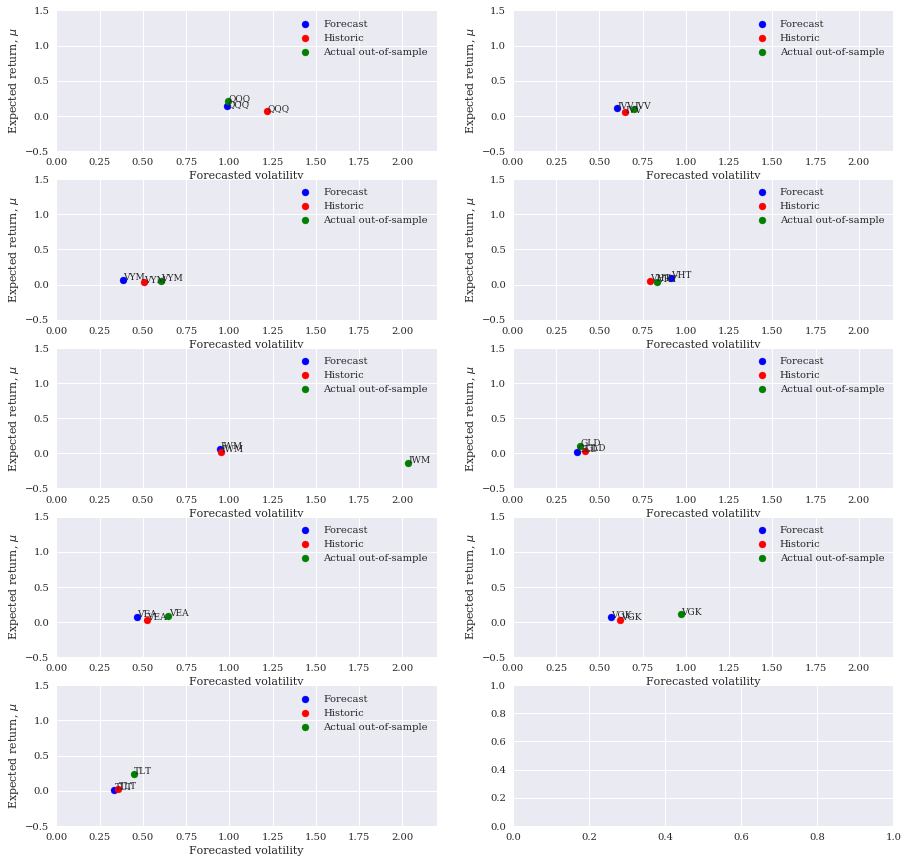

In [62]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
for i,type in enumerate(mylist):
    plt.subplot(5,2,i+1)
    x = F_var[i]
    y = F_mu[i]
    x2 = rets[type].var()
    y2 = rets[type].mean()
    
    # actual realization out-of-sample
    x3 = rets[-n_time:H][type].var()
    y3 = rets[-n_time:H][type].mean()
    
    
    plt.scatter(x, y, marker='o', color='b', label='Forecast')
    plt.scatter(x2, y2, marker='o', color='r', label='Historic')
    plt.scatter(x3, y3, marker='o', color='g', label='Actual out-of-sample')
    plt.text(x+0.002, y+0.002, type, fontsize=9)
    plt.text(x2+0.002, y2+0.002, type, fontsize=9)
    plt.text(x3+0.002, y3+0.002, type, fontsize=9)
    
    axes = plt.gca()
    axes.set_xlim([0,2.2])
    axes.set_ylim([-0.5,1.5])

    plt.xlabel('Forecasted volatility')
    plt.ylabel('Expected return, $\mu$')
    plt.legend()

plt.show()

In [287]:
#res.summary()

In [279]:
#fig = res.plot(annualize='D')

In [64]:
#help(res)

In [234]:
# forecast the test set
forecasts = res.forecast(horizon=n_test)
F_V = forecasts.variance.dropna().values.T
#F_V

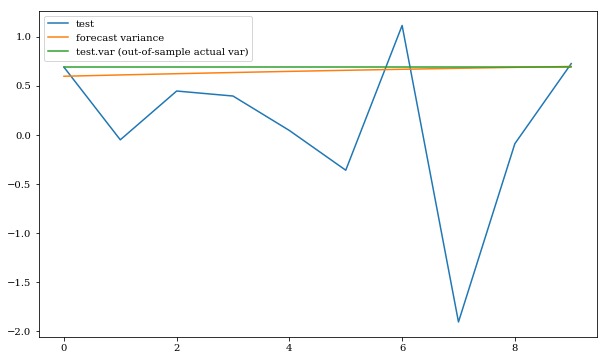

In [235]:
plt.figure(figsize=(10,6))

# plot the actual variance
var = test
plt.plot(var.values, label='test')

# plot forecast variance
plt.plot(F_V, label='forecast variance')

# plot actual out-of-sample variance
plt.plot(np.full((1,n_test), test.var()).T, label='test.var (out-of-sample actual var)')

#plt.plot(test**2, label='squared return')

plt.legend()
plt.show()

In [232]:
print(train.var())
print(train[-500:].var())
print(test.var())


0.8434734474984333
0.7323668948996758
0.6976789750530974


In [233]:
print(F_V.mean())


0.6513483651327097


In [22]:
squared_rets = rets ** 2

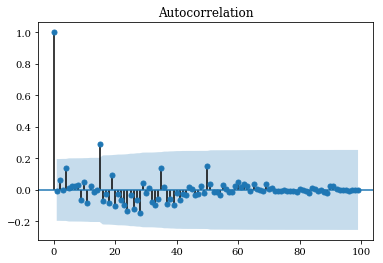

In [276]:
plot_acf(squared_rets['IVV'][-100:])
pyplot.show()

## Simulation

\begin{align}
    r_{t+1} &= \mu + \sigma_{t+1} z_{t+1} \\
    \sigma^2_{t+1} &= \omega + \alpha r_t^2 + \beta \sigma_t^2  \\
    z &\sim \textit{i.i.d. } \mathcal{N}(0,1)
\end{align}

In [33]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

In [34]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [179]:
#parameters.round(4)
parameters[1]

# Maybe don't need forecasts as we do FHS self...
# forecasts.round(2)
# forecasts[0].mean()
# forecast_vol.round(3)

array([0.10665903, 0.02589144, 0.19784684, 0.77187869])

In [288]:
# Filtered Historical Simulation

#npr.seed(741)
N = n_test # 10

SIM_RET = {}
SIM_SIGMA = {}
ACC_RET = {}
AVG_VOL = {}

# Loop over assets
for j in range(noa):

    # Define parameters for the given asset
    param = parameters[j]
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    acc_ret = []                                                   # space for accumulated returns
    avg_vol = []
    
    # Loop for simulations
    for i in range(50000):
        z = random.sample(list(std_resid[j][:-n_test]), 10)            # Bootstrap random draw from std.res.
        sim_ret = np.empty(N)                                          # Define vector for simulated return
        
        
        # Define vector for simulated sigma_(t+1) for GARCH(1,1)
        sim_sigma = np.empty(N)
        sim_sigma[0] = ((train[-1] - mu)/ std_resid[j][-n_test])
        
        # Loop for horizon
        for n in range(N-1):
            sim_ret[n] = mu + sim_sigma[n] * z[n]
            sim_sigma[n+1] =  math.sqrt(omega + alpha * sim_ret[n]**2 + beta * sim_sigma[n]**2)
        
        acc_ret.append(np.sum(sim_ret))                               # all 50.000 accumulated return
        avg_vol.append(sum(sim_sigma)/len(sim_sigma))                 # all 50.000 average sigma 

    ACC_RET["asset_{0}".format(j)] = acc_ret
    AVG_VOL["asset_{0}".format(j)] = avg_vol

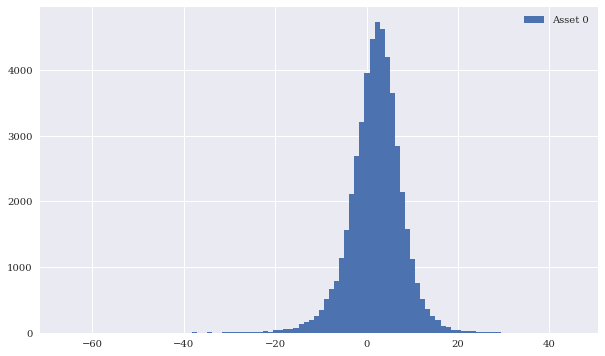

In [300]:
plt.figure(figsize=(10,6))
plt.hist(ACC_RET['asset_0'], bins=100, label='Asset 0')
#plt.hist(ACC_RET['asset_1'], bins=100, label='Asset 1') 
#plt.hist(ACC_RET['asset_2'], bins=100, label='Asset 2')
#plt.hist(ACC_RET['asset_3'], bins=100, label='Asset 3')
plt.legend()
plt.show()

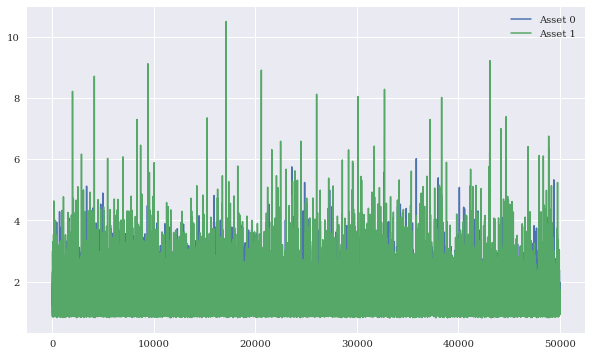

In [290]:
plt.figure(figsize=(10,6))
plt.plot(AVG_VOL['asset_0'], lw=1.5, label='Asset 0')
plt.plot(AVG_VOL['asset_1'], lw=1.5, label='Asset 1') 
plt.legend()
plt.show()

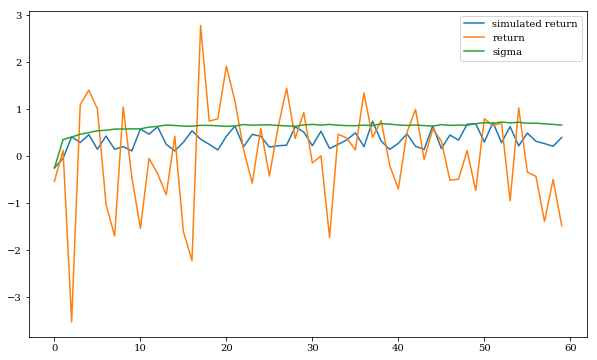

In [39]:
plt.figure(figsize=(10,6))
plt.plot(sim_ret, lw=1.5, label='simulated return')
plt.plot(var.values, lw=1.5, label='return')
plt.plot(sim_sigma, lw=1.5, label='sigma')
plt.legend()
plt.show()

In [40]:
var.var()

1.1638353654508187